## mean squared displacement in crowded system

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import readdy

In [98]:
crowded = False
name = "crowded_msd" if crowded else "free_msd"

n_particles = 1000
origin = np.array([-9.,-9.,-9.])
extent = np.array([18.,18.,18.])

data_dir = "/home/chris/workspace/data/workshop"
out_file = os.path.join(data_dir, f"{name}.h5")
checkpoint_dir = os.path.join(data_dir, f"ckpts_{name}")
n_steps = 20000
dt = 1e-2

In [99]:
system = readdy.ReactionDiffusionSystem(
    [20.,20.,20.], 
    periodic_boundary_conditions=[False, False, False],
    unit_system=None)

system.add_species("A", 0.1)

system.potentials.add_box("A", 100., origin=origin, extent=extent)

if crowded:
    system.potentials.add_harmonic_repulsion("A", "A", force_constant=100., interaction_distance=2.)

In [100]:
simulation = system.simulation("SingleCPU")
simulation.output_file = out_file

simulation.observe.particle_positions(stride=1)

if os.path.exists(checkpoint_dir):
    simulation.load_particles_from_latest_checkpoint(checkpoint_dir)
else:
    init_pos = np.random.uniform(size=(n_particles, 3)) * extent + origin
    simulation.add_particles("A", init_pos)

# this also creates the directory, if it does not exist
simulation.make_checkpoints(n_steps//100, output_directory=checkpoint_dir, max_n_saves=10)

if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)
    
simulation.run(n_steps, dt)

  1%|          | 18/2000 [00:00<00:11, 178.77it/s]

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (false, false, false)
 - box size = (20, 20, 20)
 - particle types:
     *  particle type "A" with D=0.1
 - potentials of order 1:
     * for type "A"
         * Box potential with origin=(-9, -9, -9), extent=(18, 18, 18), and force constant k=100

Configured simulation loop with:
--------------------------------
 - timeStep = 0.01
 - evaluateObservables = true
 - progressOutputStride = 10
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true
 - Performing checkpointing:
   * stride: 200
   * base path: /home/chris/workspace/data/workshop/ckpts_free_msd
   * checkpoint filename template: checkpoint_{}.h5
   * maximal number saves: 10



100%|██████████| 2000/2000 [00:10<00:00, 184.30it/s]


In [101]:
traj = readdy.Trajectory(out_file)

 Calculate MSD:
 1. Convert positions list into numpy array (TxNx3)
 2. From every particles position subtract the initial position
 3. Square this
 4. Average over particles

In [103]:
times, positions = traj.read_observable_particle_positions()

# 1
T = len(positions)
N = len(positions[0])
pos = np.zeros(shape=(T, N, 3))
for t in tqdm(range(T)):
    for n in range(N):
        pos[t, n, 0] = positions[t][n][0]
        pos[t, n, 1] = positions[t][n][1]
        pos[t, n, 2] = positions[t][n][2]

# 2
difference = pos - pos[0]

# 3
squared_displacements = np.sum(difference * difference, axis=2)  # sum over coordinates, per particle per timestep

# 4
squared_displacements = squared_displacements.transpose()  # T x N -> N x T
mean = np.mean(squared_displacements, axis=0)

std_dev = np.std(squared_displacements, axis=0)
std_err = np.std(squared_displacements, axis=0) / np.sqrt(len(squared_displacements))

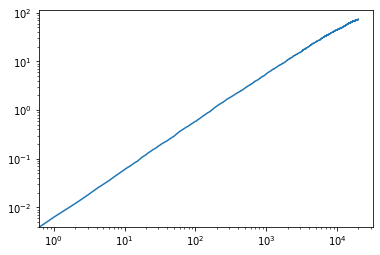

In [104]:
plt.plot(times, mean)
plt.xscale("log")
plt.yscale("log")

In [105]:
if crowded:
    times_crowded = times
    mean_crowded = mean
else:
    times_free = times
    mean_free = mean

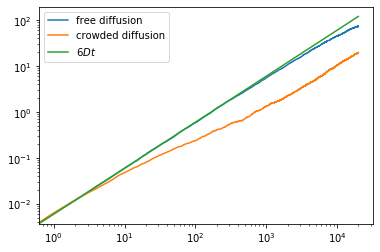

In [107]:
plt.plot(times_free, mean_free, label="free diffusion")
plt.plot(times_crowded, mean_crowded, label="crowded diffusion")
plt.plot(times_free, 6.*0.1*times_free*dt, label=r"$6Dt$")
plt.xscale("log")
plt.yscale("log")
plt.legend()

- initially all show normal diffusion with self diffusion coefficient $D$
- crowded shows subdiffusion (lower exponent than 2) on intermediate timescales, while free diffusion is still normal diffusion
- crowded shows normal diffusion with reduced diffusion coefficient
- all curves must saturate, since the box is closed and not periodic